### Collaborators - Andrew Zolintakis and Sagnik Rana<br>
#### The project is about predicting whether a breast mass will be a malign cancer or benign cancer.<br>
#### Breast cancer is a growing problem for the entire world. According to cancer.net, This year, an estimated 268,600 women in the United States will be diagnosed with breast cancer and it is also estimated that 42,260 deaths (41,760 women and 500 men) from breast cancer will occur this year. <br>
#### It is exceedingly important for us to figure out technology which can help doctors to identify the cases as quickly as possible. Our main aim is to expedite the current process of cancer identification techniques and to minimize the type 2 errors, which  could be fatal in this case.


In [1]:
# importing the packages

import seaborn as sns
import numpy as np
import pandas as pd
import plotly.tools as tls
import plotly.offline as py
import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
import numpy as np

from matplotlib.pyplot import figure
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes,\
                                      MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, \
                            roc_auc_score, roc_curve,precision_score, f1_score


Data Information:

1) ID number 2) Diagnosis (M = malignant, B = benign) 3-32)

Ten real-valued features are computed for each cell nucleus:

a) radius (mean of distances from center to points on the perimeter) b) texture (standard deviation of gray-scale values) c) perimeter d) area e) smoothness (local variation in radius lengths) f) compactness (perimeter^2 / area - 1.0) g) concavity (severity of concave portions of the contour) h) concave points (number of concave portions of the contour) i) symmetry j) fractal dimension ("coastline approximation" - 1)

The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

All feature values are recoded with four significant digits.

Missing attribute values: none

Class distribution: 357 benign, 212 malignant

In [2]:
def plot_3d_relation(dataframe,col1,col2,col3):
    '''
    This function plots the 3D scatter plot for a dataframe
    and 3 columns, which it takes up as x, y and z axis
    Parameters:
    dataframe: Name of the dataframe
    col1: x axis
    col2: y axis
    col3: z axis
    '''
    trace1 = go.Scatter3d(
        x=(dataframe[col1]).tolist(),
        y=(dataframe[col2]).tolist(),
        z=(dataframe[col3]).tolist(),
        name = "Malign cancer",
        mode='markers',
        marker=dict(
            color='red',
            size=12,
            symbol='circle',
            line=dict(
                color='white',
                width=1
            ),
            opacity=0.9
        )
    )

    trace2 = go.Scatter3d(
        x=(bc_benign.iloc[:,4]).tolist(),
        y=(bc_benign.iloc[:,8]).tolist(),
        z=(bc_benign.iloc[:,9]).tolist(),
        name = "benign cancer",
        mode='markers',
        marker=dict(
            color='green',
            size=12,
            symbol='circle',
            line=dict(
                color='white',
                width=1
            ),
            opacity=0.9
        )
    )

    data = [trace1,trace2]
    layout = go.Layout(dict(title = "Classification of cancers - Benign or Malign",
                            scene = dict(camera = dict(up=dict(x= 0 , y=0, z=0),
                                                       center=dict(x=0, y=0, z=0),
                                                       eye=dict(x=1.25, y=1.25, z=1.25)),
                                         xaxis  = dict(title = col1,
                                                       gridcolor='rgb(255, 255, 255)',
                                                       zerolinecolor='rgb(255, 255, 255)',
                                                       showbackground=True,
                                                       backgroundcolor='rgb(254,224,144)'),
                                         yaxis  = dict(title = col2,
                                                       gridcolor='rgb(255, 255, 255)',
                                                       zerolinecolor='rgb(255, 255, 255)',
                                                       showbackground=True,
                                                       backgroundcolor='rgb(254,224,144)'
                                                      ),
                                         zaxis  = dict(title = col3,
                                                       gridcolor='rgb(255, 255, 255)',
                                                       zerolinecolor='rgb(255, 255, 255)',
                                                       showbackground=True,
                                                       backgroundcolor='rgb(254,224,144)'
                                                      )
                                        ),
                            height = 900,
                           )
                      )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='3d-scatter-colorscale')

## Exploratory Data Analysis

In [3]:
# Reading the dataframe
df = pd.read_csv('data.csv').iloc[:,:-1]

In [4]:
# Viewing the dataset
df.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

            ...             radius_worst  texture_worst  perimeter_worst  \
0           ...                    25.38          17.33           184.60   
1           ...                    24.99          23.41           158.80   
2           ...                    23.57          25.53           152.50   
3           ...                    14.91          26.50            98.87   
4           ...                    22.54          16.67           152.20   

   area_worst  smoothness_worst  compactness_worst  concavity_worst  \
0      2019.0            0.1622             0.6656           0.7119   
1      1956.0            0.1238             0.1866           0.2416   
2      1709.0            0.1444             0.4245           0.4504   
3       567.7            0.2098             0.8663           0.6869   
4      1575.0            0.1374             0.2050           0.4000   

   concave points_worst  symmetry_worst  fractal_dimension_worst  
0                0.2654          0.4601                  0.11890  
1                0.1860          0.2750                  0.08902  
2                0.2430          0.3613                  0.08758  
3                0.2575          0.6638                  0.17300  
4                0.1625          0.2364                  0.07678  

[5 rows x 32 columns]

In [5]:
# Viewing the columns
df.columns.values[1:]

array(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'symmetry_mean',
       'fractal_dimension_mean', 'radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se',
       'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'], dtype=object)

In [6]:
data = spark.read.csv('data.csv', header='true', inferSchema='true')
data = data.select([column for column in data.columns if column not in ['_c32', 'id']])
all_features = [x for x in data.columns if x not in ['diagnosis']]

## Outlier Analysis through boxplots

radius_mean


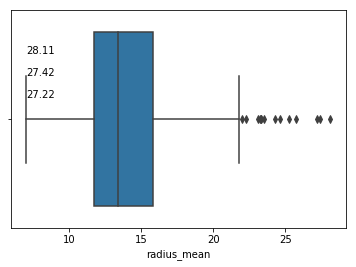

texture_mean


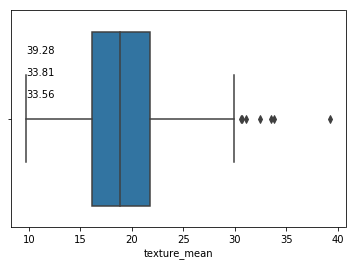

perimeter_mean


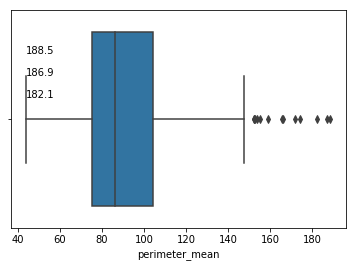

area_mean


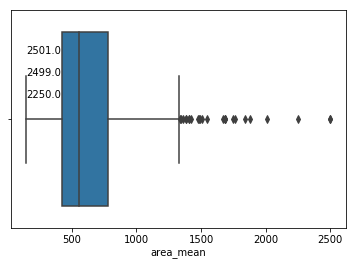

smoothness_mean


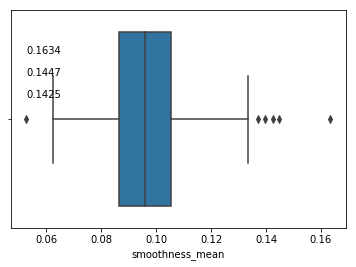

compactness_mean


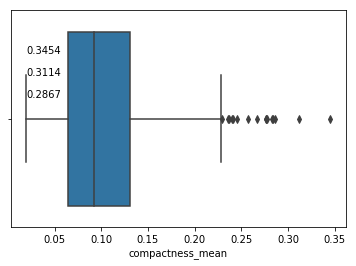

concavity_mean


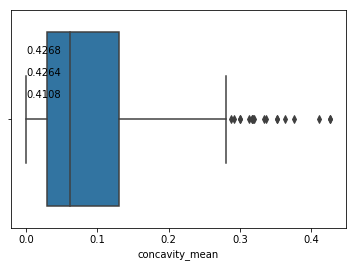

concave points_mean


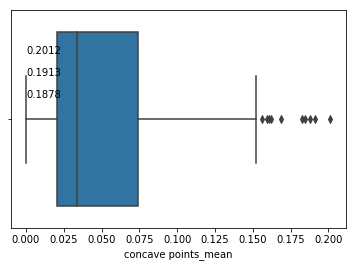

symmetry_mean


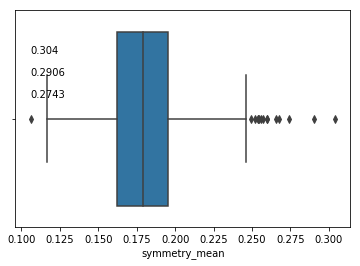

fractal_dimension_mean


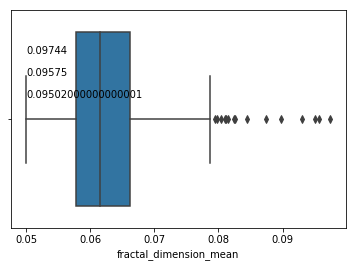

radius_se


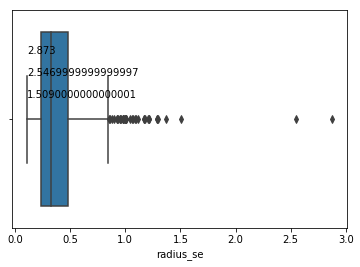

texture_se


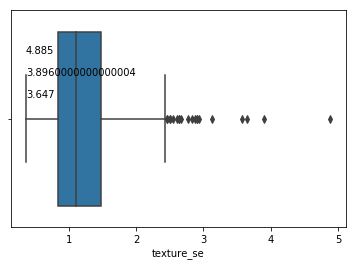

perimeter_se


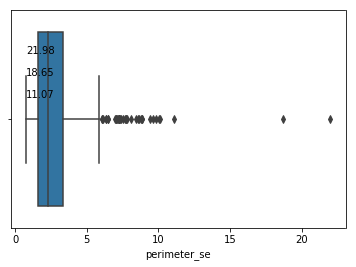

area_se


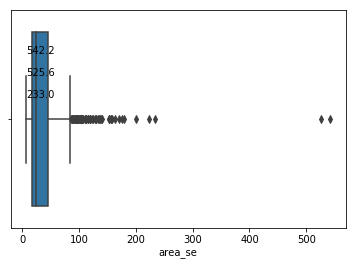

smoothness_se


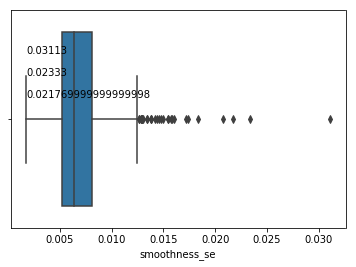

compactness_se


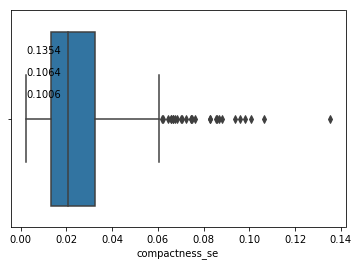

concavity_se


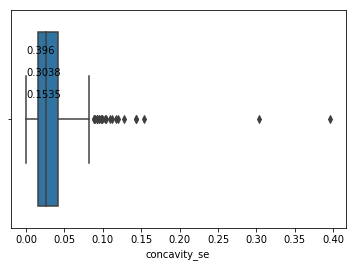

concave points_se


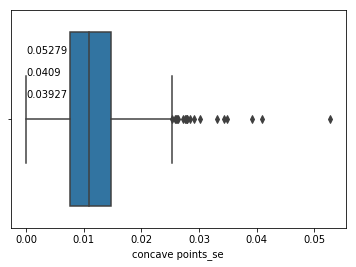

symmetry_se


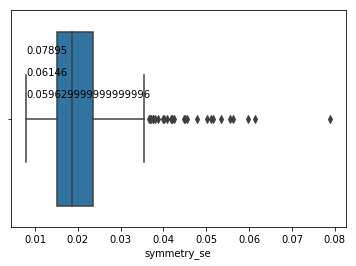

fractal_dimension_se


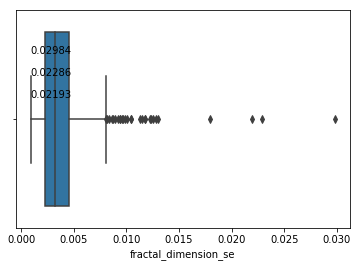

radius_worst


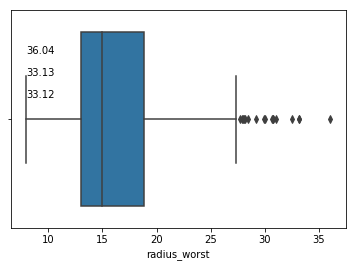

texture_worst


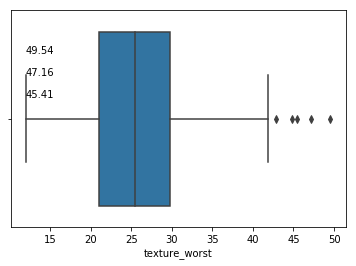

perimeter_worst


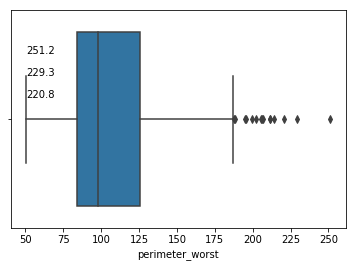

area_worst


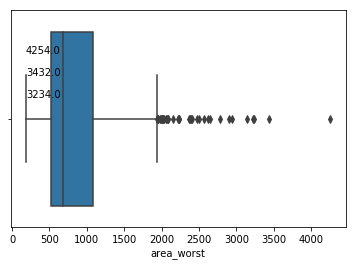

smoothness_worst


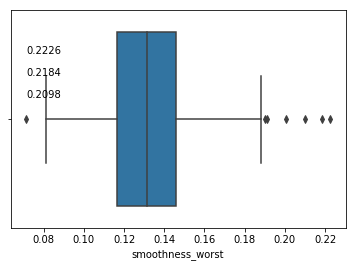

compactness_worst


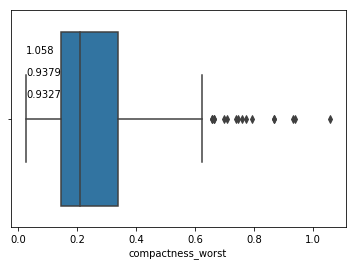

concavity_worst


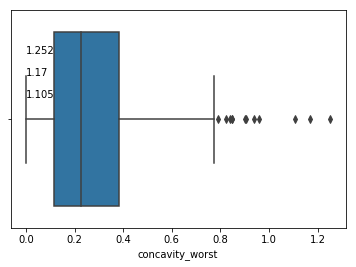

concave points_worst


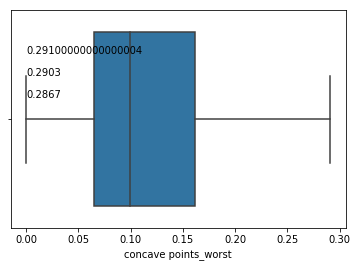

symmetry_worst


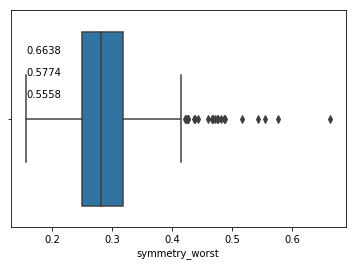

fractal_dimension_worst


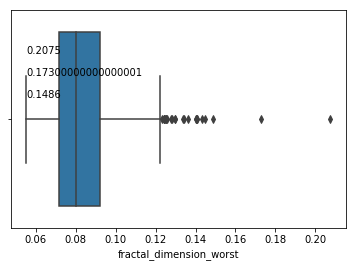

In [7]:
for i in df.columns.values[2:]:
    print(i)
    sns.boxplot(df[i])

    # Print the three highest values
    highest_vals = list(df[i].nlargest(3)) # get 3 highest values

    smallest_val = min(df[i])

    plt.text(smallest_val, -0.3, highest_vals[0])
    plt.text(smallest_val, -0.2, highest_vals[1])
    plt.text(smallest_val, -0.1, highest_vals[2])

    plt.show()

## Correlation Analysis

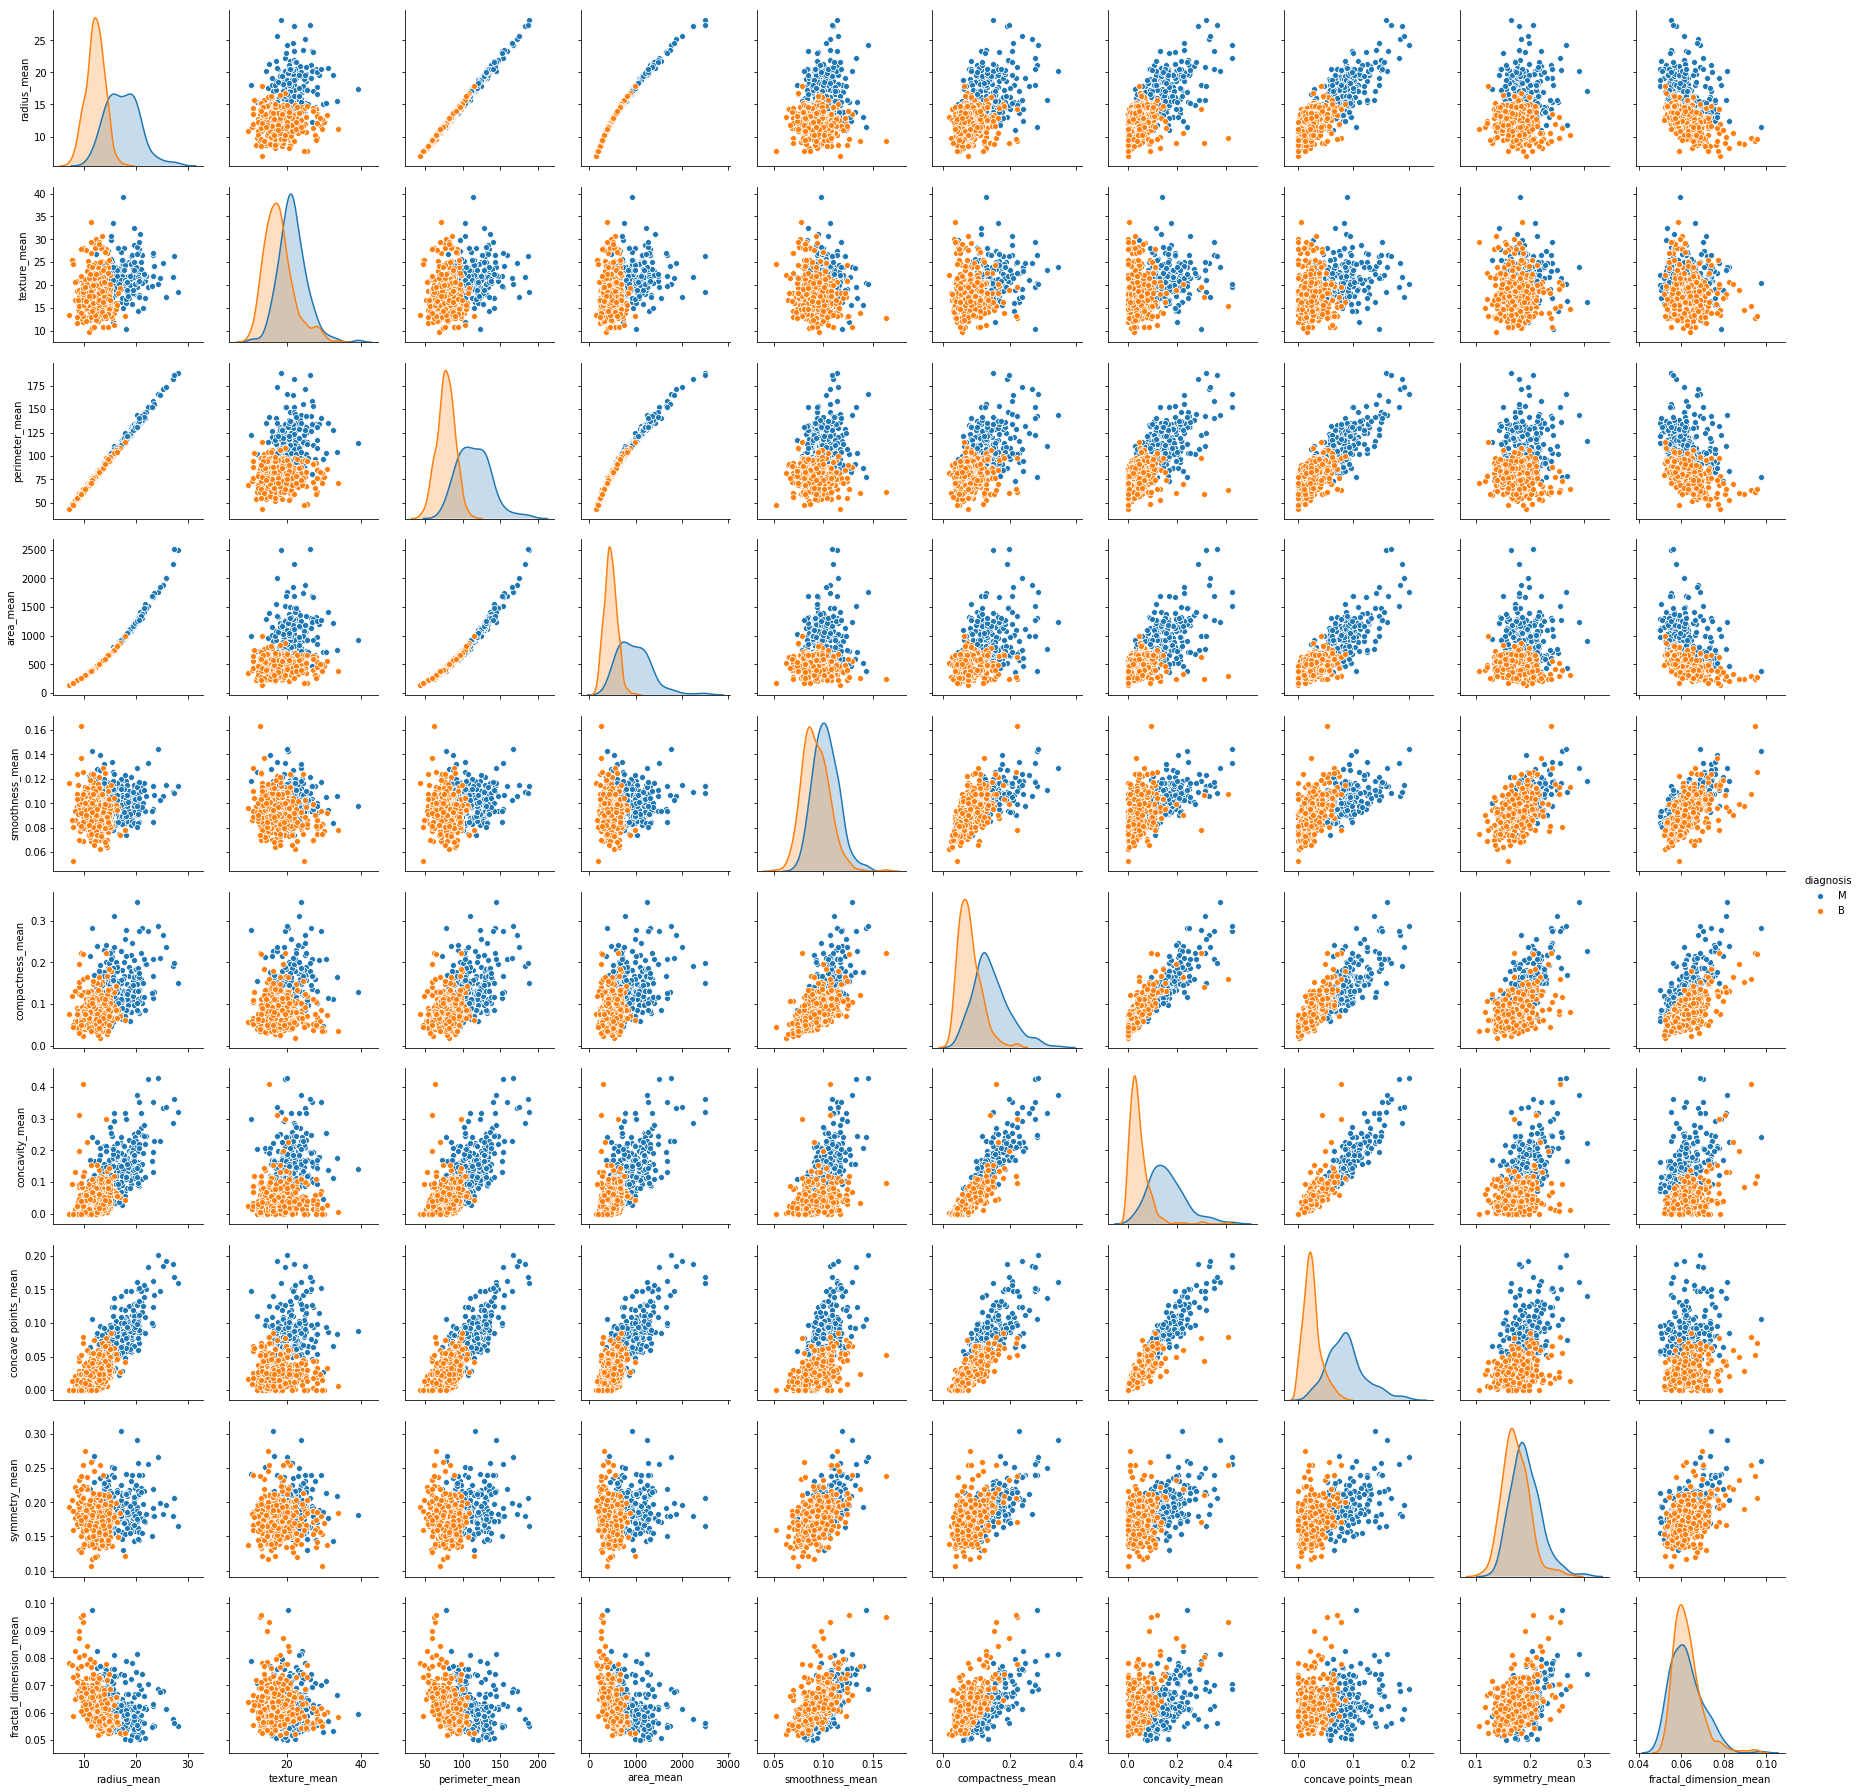

In [8]:
# Viewing how they are correlated with each other
sns.pairplot(df, hue='diagnosis' ,vars=df.columns.values[2:12])

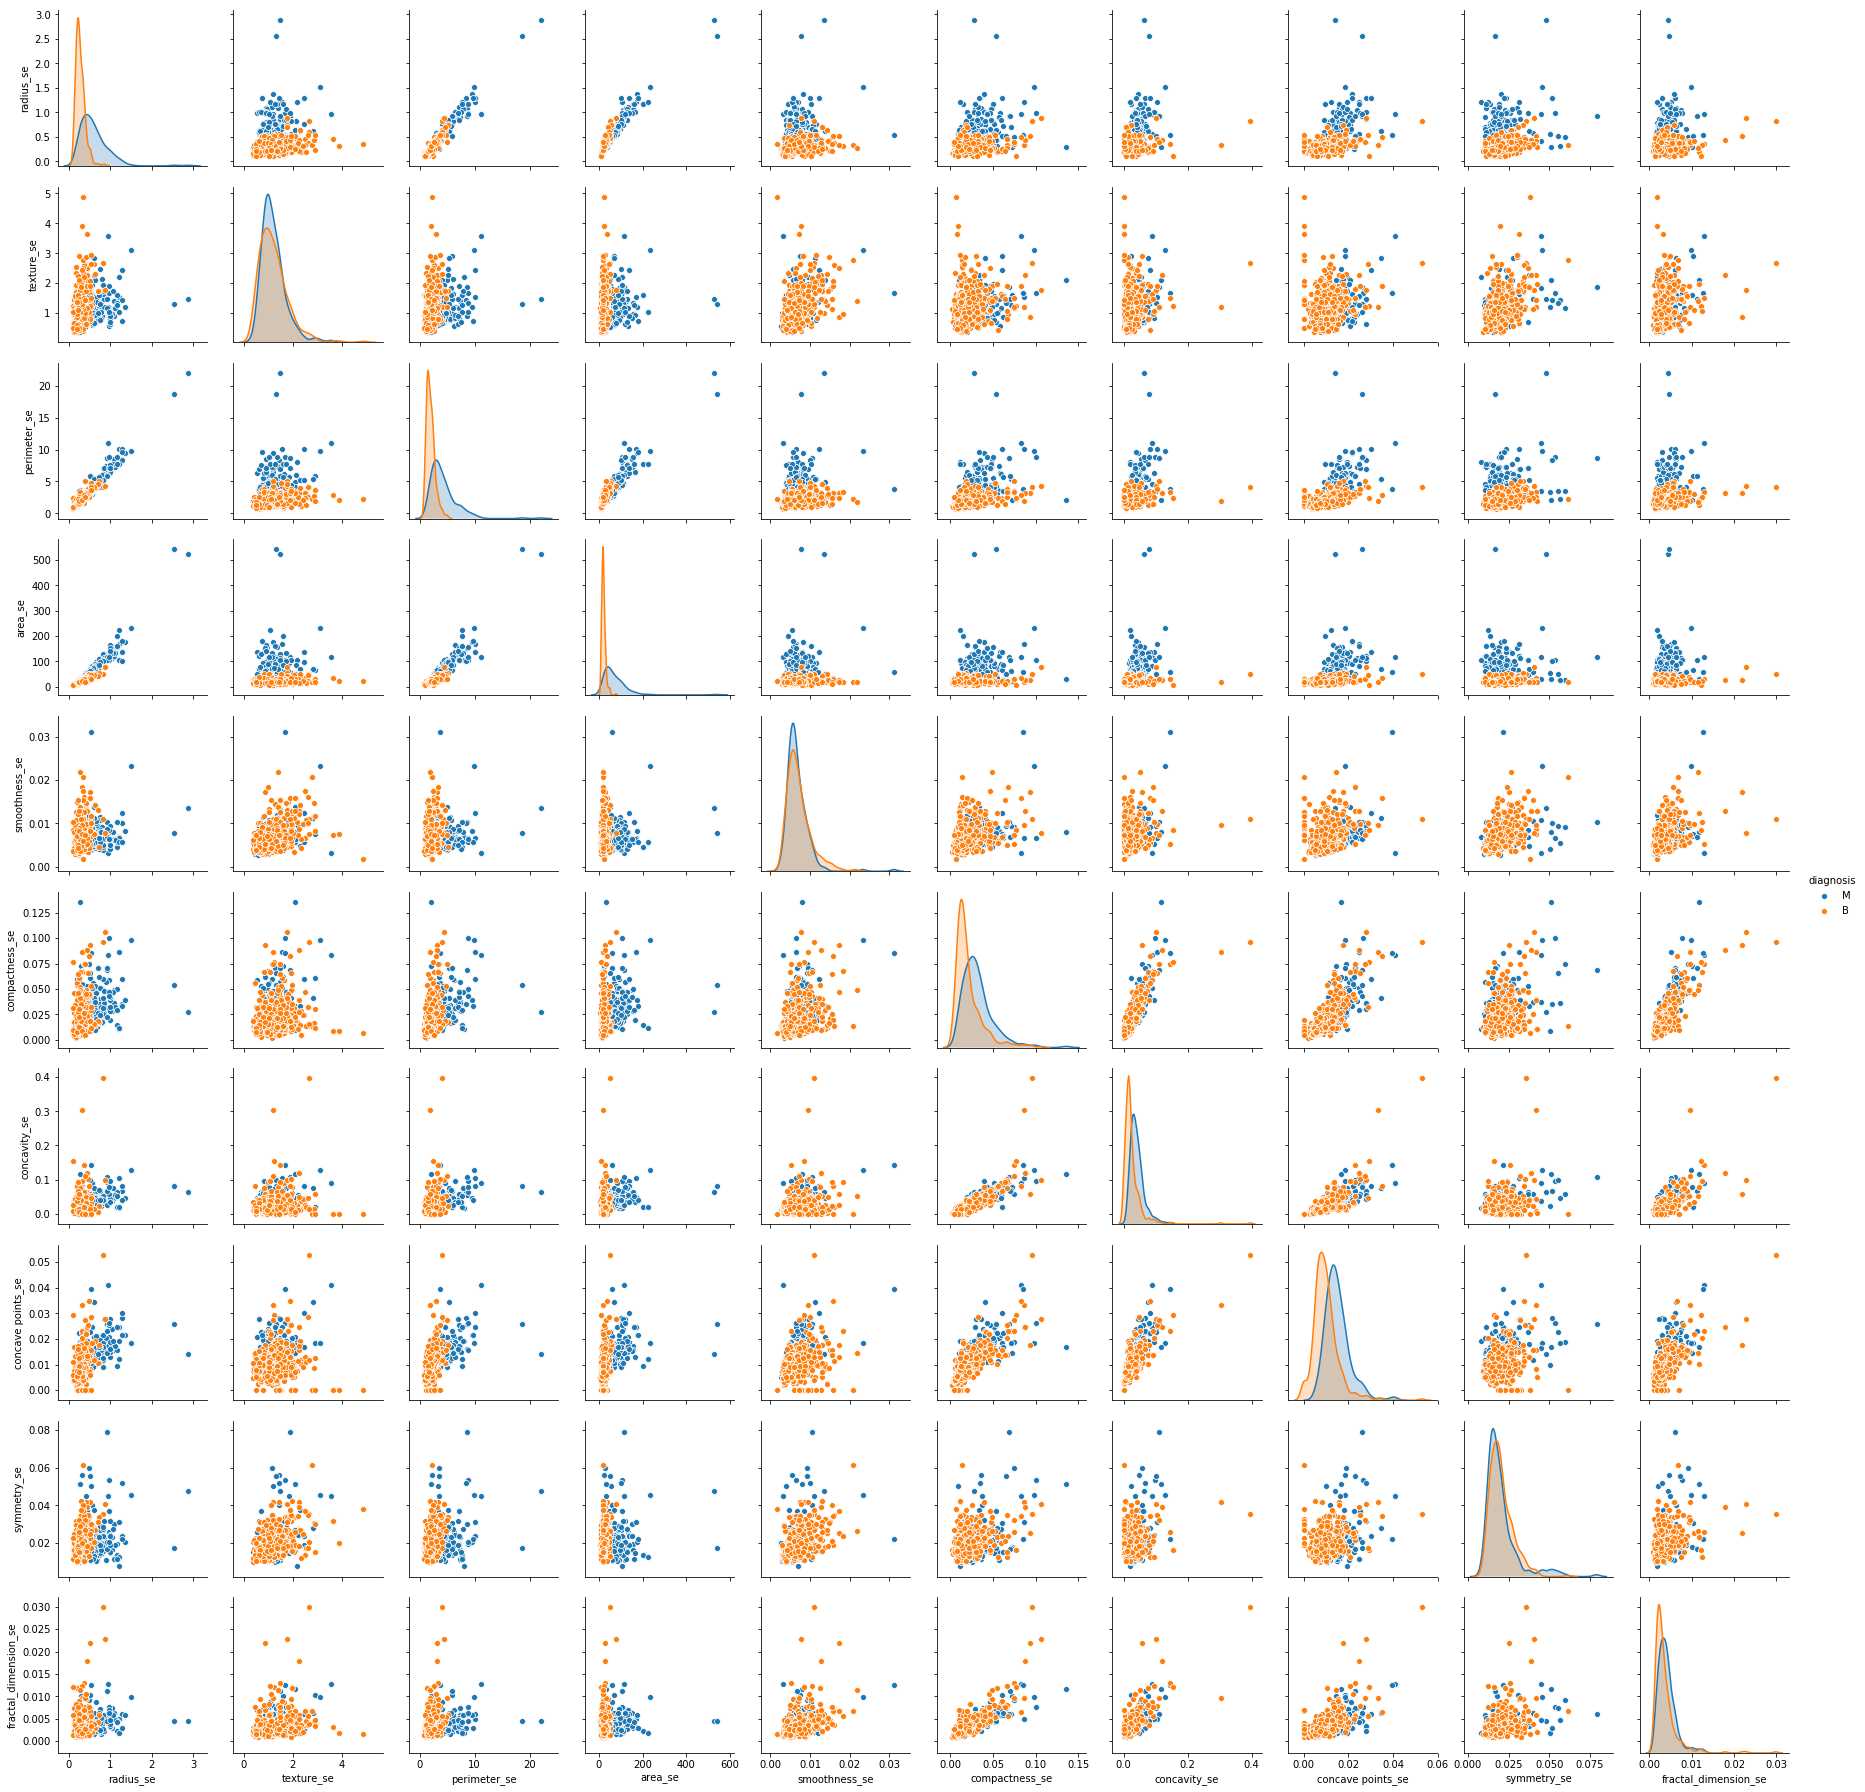

In [9]:
sns.pairplot(df, hue='diagnosis' ,vars=df.columns.values[12:22])

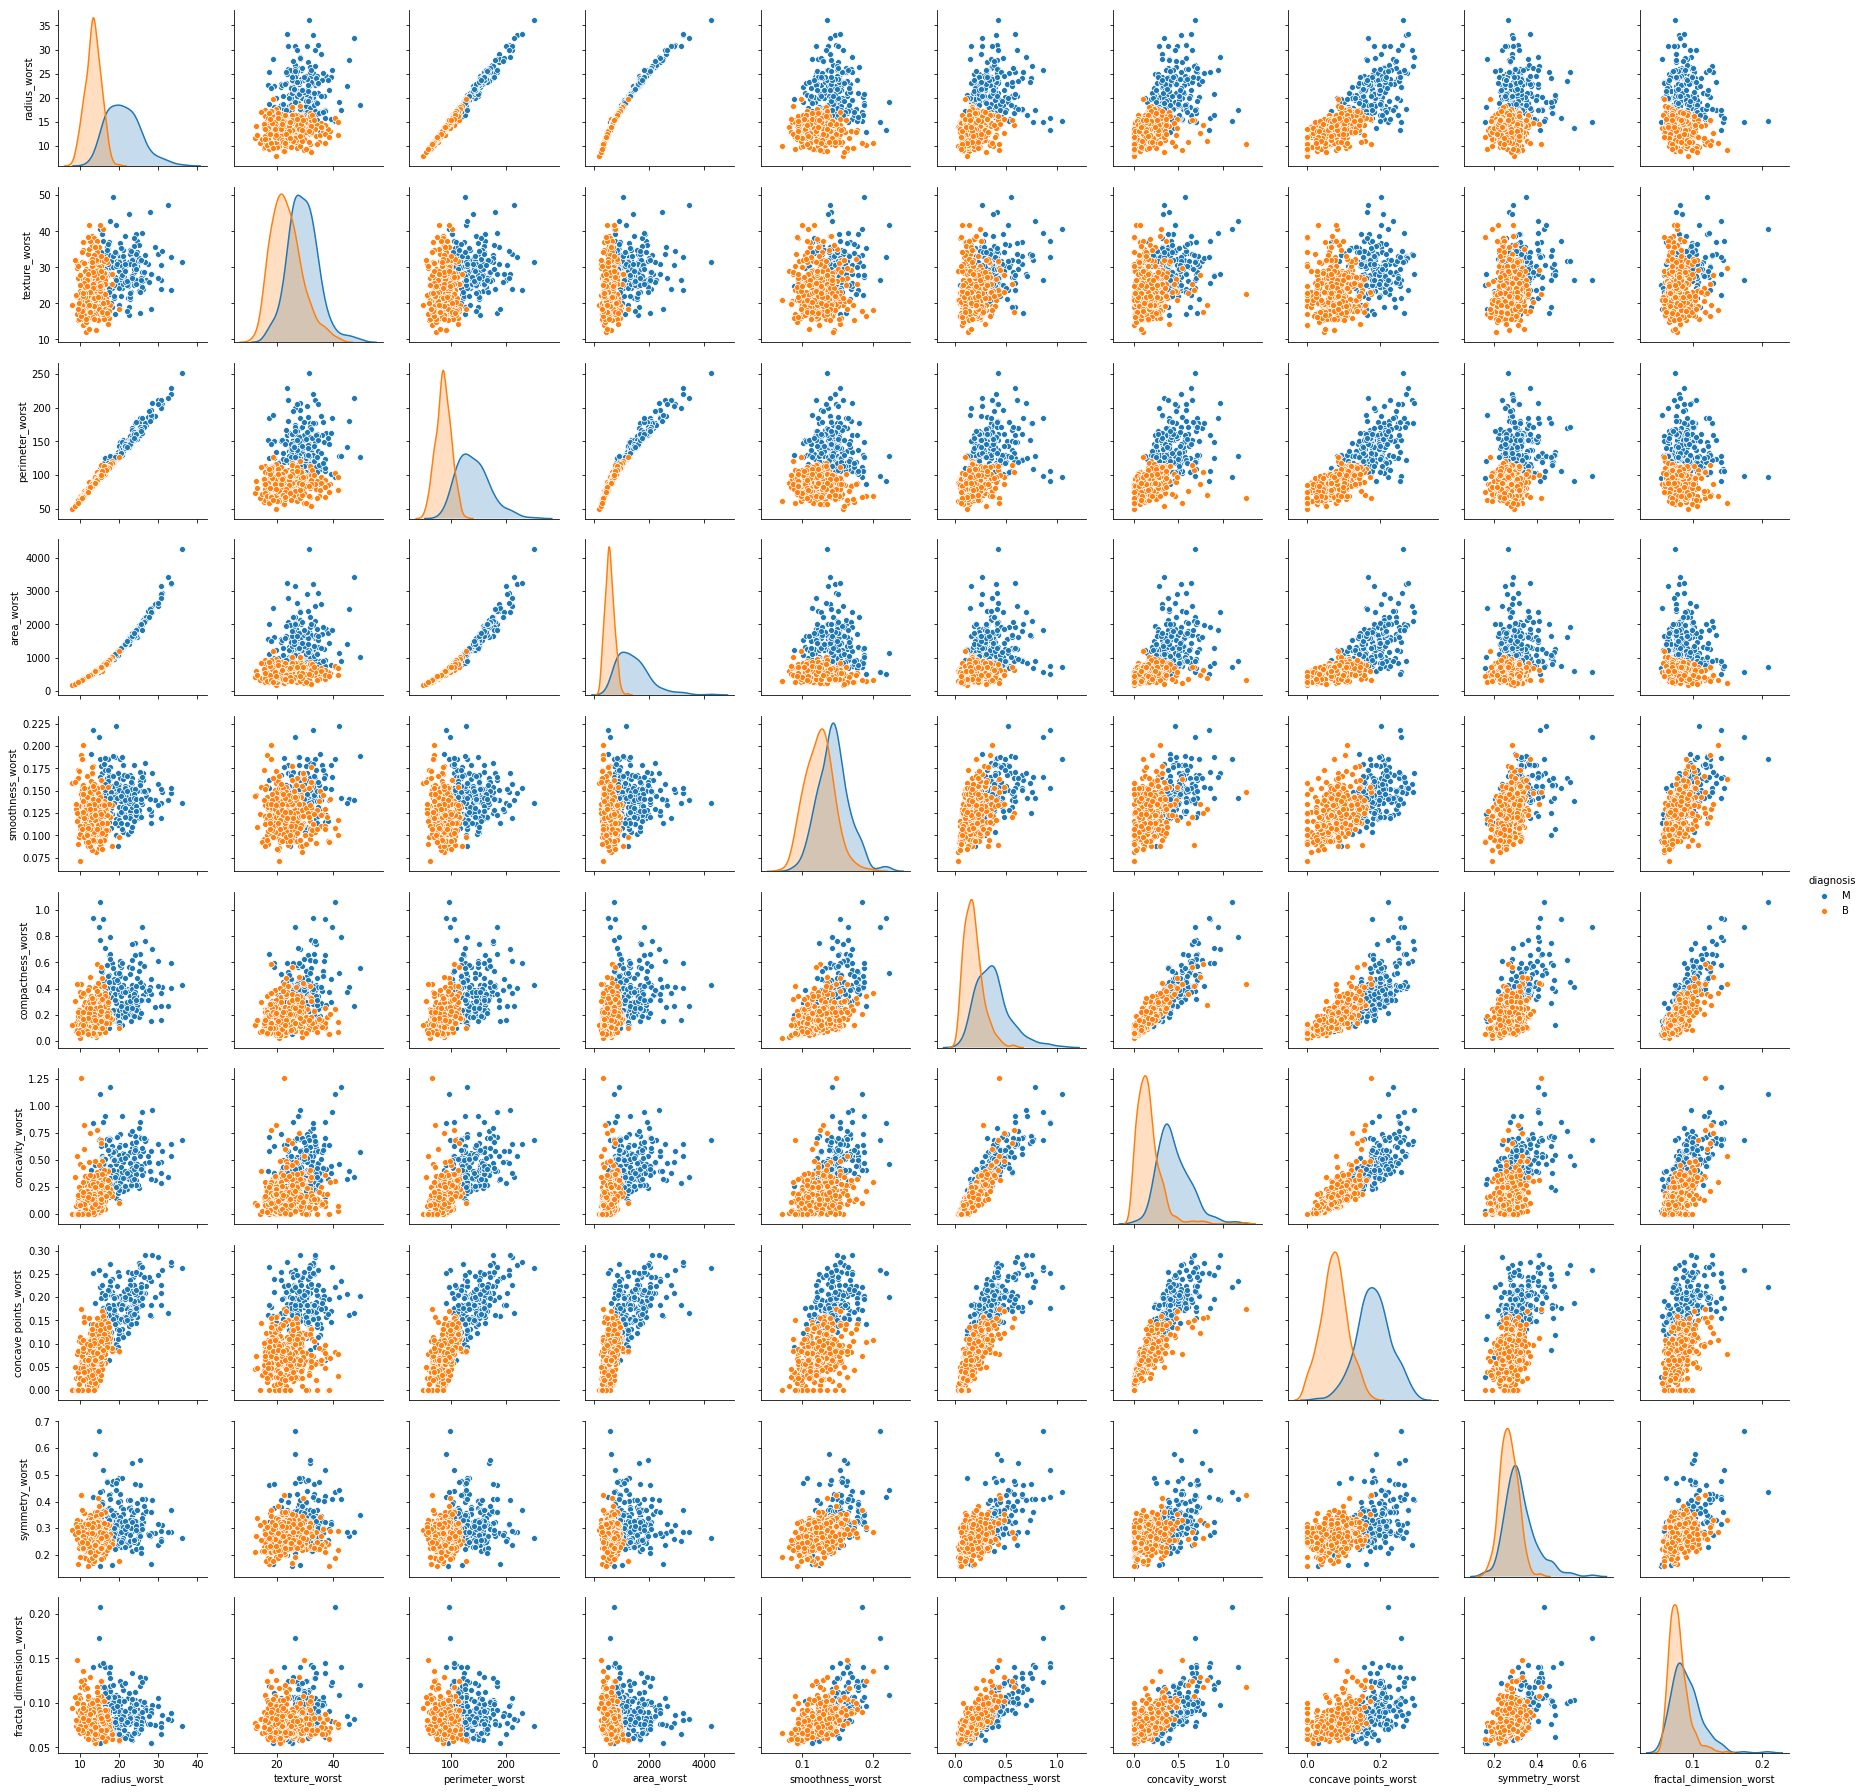

In [10]:
sns.pairplot(df, hue='diagnosis' ,vars=df.columns.values[22:])

### Interpretation: <br>
The above plots show the relationship between all the features and how they corelate with each other. The two different colors show the classes. This is a good news for us as clustering is showing us how differentiable the classes are for every two features.

## Dimensionality Reduction

### PCA

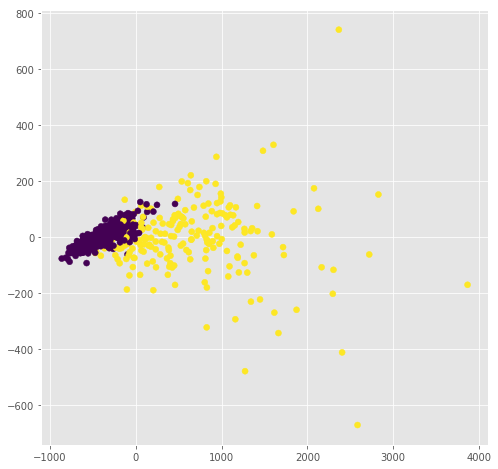

In [11]:
from sklearn.decomposition import PCA

X = df.iloc[:,2:].as_matrix()
y= pd.get_dummies(df['diagnosis'])['M'].as_matrix()


pca = PCA(n_components=2)
pca_dimensions = pca.fit_transform(X)
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
plt.scatter(pca_dimensions[:,0], pca_dimensions[:,1], c=y)
plt.show()

### PCA helps us to identify the naked patterns with the data and in this graph, we can see that we have two clear clusters of the data. Most likely, they relates with the pairplots where we saw good clusters getting formed with the benign and malign labels.

In [12]:
pca.explained_variance_ratio_

array([0.98204467, 0.01617649])

### The first component is able to explain the 98% of the variance, which is excellent.

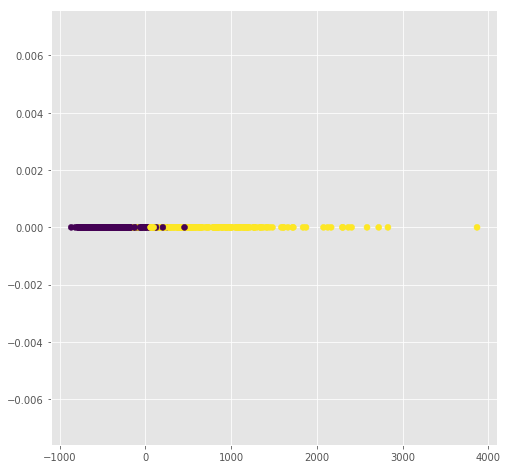

In [13]:
single_dim_pca = PCA(n_components=1)
single_dimension = single_dim_pca.fit_transform(X)
y_axis_all_zeros = np.zeros(len(single_dimension))
plt.figure(figsize = (8,8))
plt.style.use('ggplot')
plt.scatter(single_dimension[:,0], y_axis_all_zeros, c=y)
plt.show()

### This is the representation of the data in one dimension. If it is so much separable in the first dimension, then we can say that it will be much much separable in higher dimensions as well.

In [14]:
single_dim_pca.explained_variance_ratio_

array([0.98204467])

### T-SNE

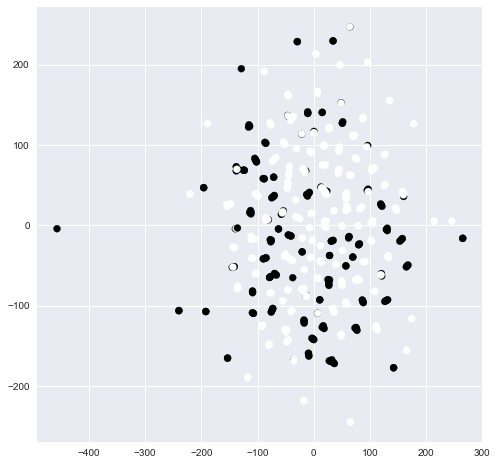

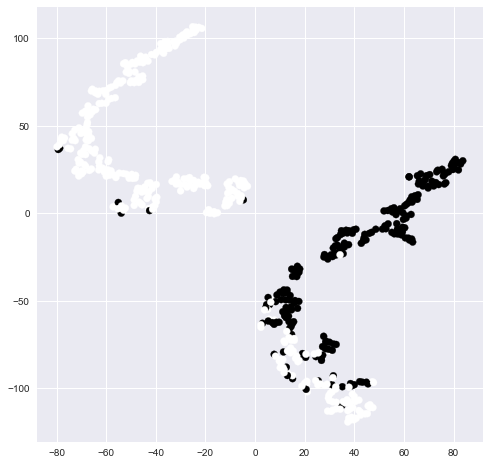

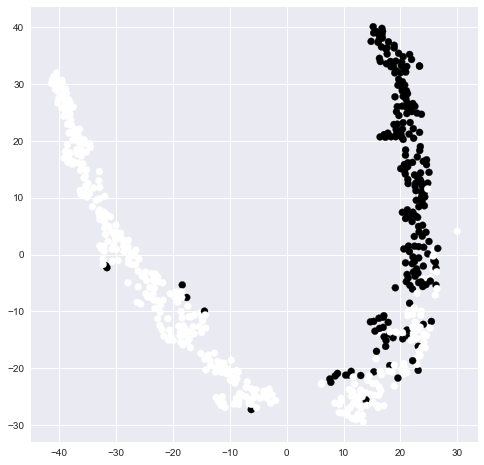

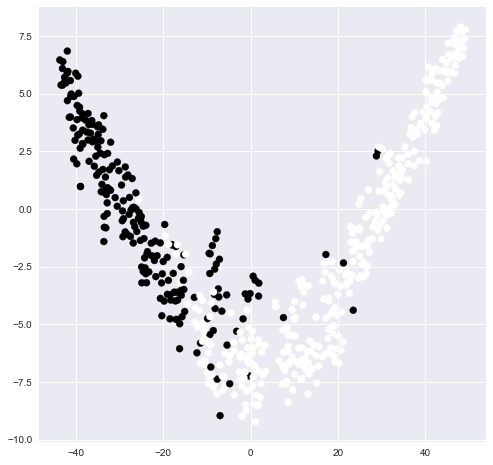

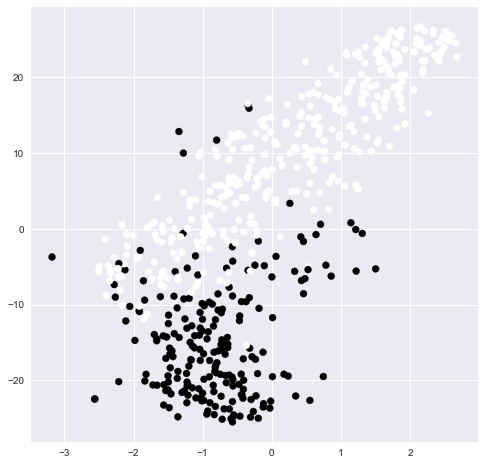

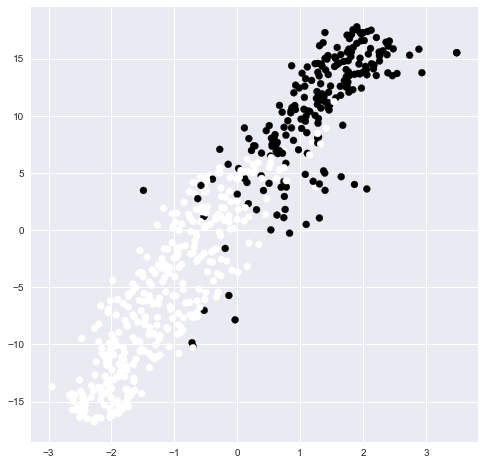

In [15]:
from sklearn.manifold import TSNE

perplexities = [1,10,25,40,70,100]

# looping through perplexities to catch any disorganization in various non-linear relationships
for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, n_iter=5000)
    feature_vectors_tsne2d = tsne.fit_transform(X)
    plt.figure(figsize = (8,8))
    plt.style.use('seaborn')
    plt.scatter(feature_vectors_tsne2d[:, 0], feature_vectors_tsne2d[:, 1], c=y)
    plt.show()

### The above graph shows the possible non-linear relationships in the features over a high dimension. PCA works on mathematical approach (co-variance, eigen vector and eigen value) but t-SNE works on probabilistic approach to pick up the most probable points in the feature space. It can help us to spot the non-linearities in the data set.

In [16]:
df = pd.read_csv('data.csv')
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nUnique values :  \n",df.nunique())

Rows     :  569
Columns  :  33

Features : 
 ['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']

Unique values :  
 id                         569
diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimens

  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0         M     1.096100     -2.071512        1.268817   0.983510   
1         M     1.828212     -0.353322        1.684473   1.907030   
2         M     1.578499      0.455786        1.565126   1.557513   
3         M    -0.768233      0.253509       -0.592166  -0.763792   
4         M     1.748758     -1.150804        1.775011   1.824624   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0         1.567087          3.280628        2.650542             2.530249   
1        -0.826235         -0.486643       -0.023825             0.547662   
2         0.941382          1.052000        1.362280             2.035440   
3         3.280667          3.399917        1.914213             1.450431   
4         0.280125          0.538866        1.369806             1.427237   

   symmetry_mean  fractal_dimension_mean  
0       2.215566                2.253764  
1       0.001391               -0.86

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

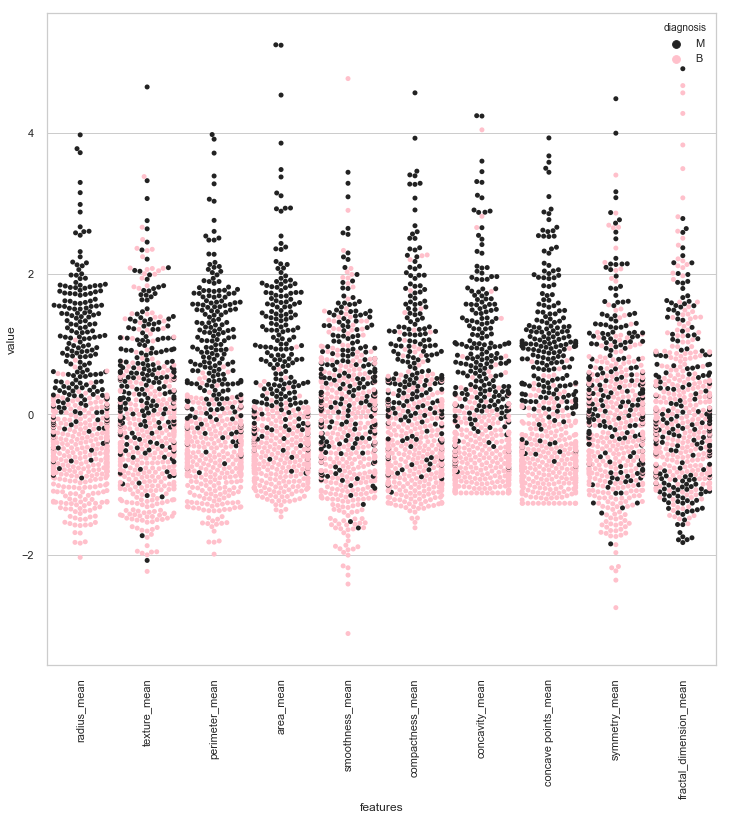

In [17]:
# y includes our labels and x includes our features
target = df.diagnosis                          # M or B 
features = df.drop(['Unnamed: 32','id','diagnosis'],axis = 1 )

sns.set(style="whitegrid", palette="muted")
bc_target = target
bc_features = features
bc_features_scaled = (bc_features - bc_features.mean()) / (bc_features.std())
bc_swarm = pd.concat([bc_target,bc_features_scaled.iloc[:,0:10]],axis=1)
print(bc_swarm.head())
bc_swarm = pd.melt(bc_swarm,
                   id_vars="diagnosis",
                   var_name="features",
                   value_name='value')
print("********************************")
print(bc_swarm.head())
plt.figure(figsize=(12,12))
sns.swarmplot(x="features", y="value", hue="diagnosis", data = bc_swarm, color='pink')
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

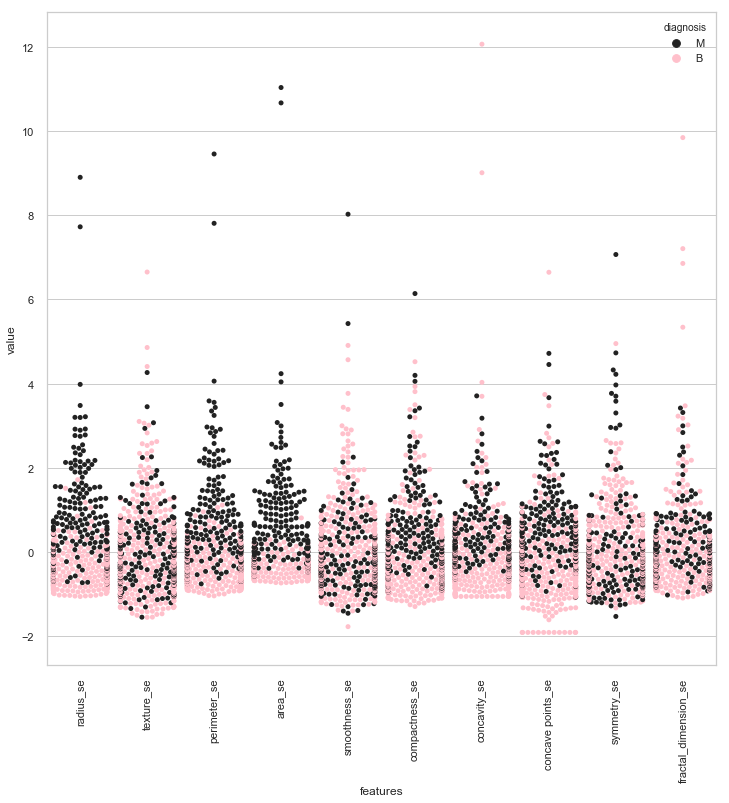

In [18]:
bc_swarm1 = pd.concat([bc_target,bc_features_scaled.iloc[:,10:20]],axis=1)

bc_swarm = pd.melt(bc_swarm1,
                   id_vars="diagnosis",
                   var_name="features",
                   value_name='value')
plt.figure(figsize=(12,12))
sns.swarmplot(x="features", y="value", hue="diagnosis", data = bc_swarm, color='pink')
plt.xticks(rotation=90)

#### After looking at the features, we can see really good clusters and those will be helpful in determining which clusters we want to choose for machine learning part. There are many features which are not quite separable, such as the texture, symmetry and fractal dimension. We will try to plot them in the 3D scatter plots to determine whether the clusters are separable of not. This is very important to do the feature enginnering for the models.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

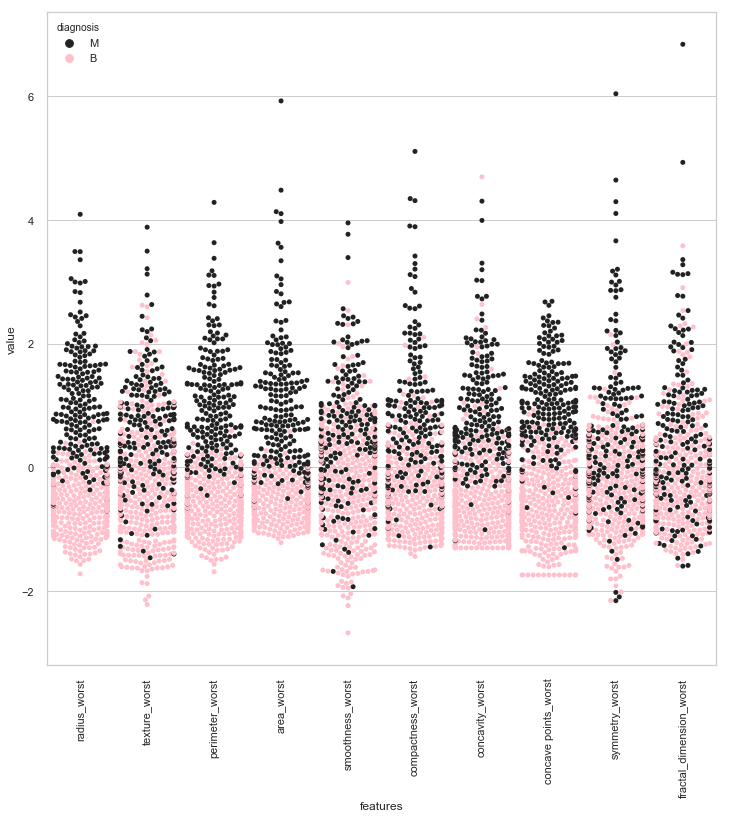

In [19]:
bc_swarm = pd.concat([bc_target,bc_features_scaled.iloc[:,20:31]],axis=1)
bc_swarm = pd.melt(bc_swarm,
                   id_vars="diagnosis",
                   var_name="features",
                   value_name='value')
plt.figure(figsize=(12,12))
sns.swarmplot(x="features", y="value", hue="diagnosis", data = bc_swarm, color='pink')
plt.xticks(rotation=90)

### Interpretation:
To distinguish how the values of individual features are determining the final target variable, we utilized swarm plot, which are available in the seaborn package. <br>
In the first set of features, we have the mean category of all the features and we can see concavity and concave points are good identifiers of benign and malign cancers.<br> In the similar way, smoothness mean and fractal dimension mean are not determining the malign and benign cancers very clearly.<br>
This is the swarm plot representation of standard error where we really cannot see the sharp boundaries here. But in some of the cases, such as compactness and concavity are helping us to separate the two classes.<br>
The worst category is clearly defining the boundaries and we can see that radius, perimeter and concavity are the leading features to determine the classes of the cancers.


In [20]:
bc_swarm = pd.concat([bc_target,bc_features_scaled],axis=1)
bc_malign = bc_swarm[bc_swarm['diagnosis'] == 'M']
bc_benign = bc_swarm[bc_swarm['diagnosis'] == 'B']

plot_3d_relation(bc_malign,'smoothness_mean','symmetry_mean','fractal_dimension_mean')

plot_3d_relation(bc_malign,'texture_se','smoothness_se','symmetry_se')

<img src='3Dplot - 1.png'>
<img src='3Dplot.png'>

### This 3D scatter plot shows that the features which were not separable in the swarmplot, are separable when plotted in a 3D space. We can clearly see the clusters and we can firmly say that if we look at them together, it can provide the doctors crucial insights.

In [21]:
#Pearson correlation
correlation = bc_swarm.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array  = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar   = dict(title = "Pearson Correlation coefficient",
                                     titleside = "right"
                                    ) ,
                  )

layout = go.Layout(dict(title = "Correlation Matrix for variables",
                        autosize = False,
                        height  = 720,
                        width   = 800,
                        margin  = dict(r = 0 ,l = 210,
                                       t = 25,b = 210,
                                      ),
                        yaxis   = dict(tickfont = dict(size = 9)),
                        xaxis   = dict(tickfont = dict(size = 9))
                       )
                  )

data1 = [trace]
fig = go.Figure(data=data1,layout=layout)
py.iplot(fig)

<img src='corelation.png'>

### Interpretation:
The pearson corelation matrix shows the corelation between all the features. Pearson coefficient generally shows which feature is increasing/decreasing with respect to what features. This gives us a fair idea which features are related with each other.

## Model Training



#### Split Data

In [6]:
data = spark.read.csv('data.csv', header='true', inferSchema='true')
data = data.select([column for column in data.columns if column not in ['_c32', 'id']])
all_features = [x for x in data.columns if x not in ['diagnosis']]

In [7]:
(trainingData, testData) = data.randomSplit([0.7, 0.3])

#### Run cross validation with to  evaluate different classification models

In [4]:
# model score lists
Models = []
Accuracy = []
AUC = []
F1 = []
Precision = []
Recall = []

In [24]:
def fit_classification(model, params=None, features=all_features,numFolds=10, model_name='model', print_to_screen=True):
    
    '''
    For specified model run 10-fold cross validation
    and return the best model. Record the accuracy, roc-auc,
    f1_score, recall, and precision scores for the best model 
    on the test data
    '''
    
    # Prepare Data
    label_indexer = StringIndexer(inputCol = "diagnosis", outputCol = "label")
    assembler = VectorAssembler(
        inputCols=[x for x in data.columns if x in features],
        outputCol='features')
    pipeline = Pipeline(stages=[assembler,label_indexer])
    pf = pipeline.fit(data)
    train = pf.transform(trainingData)
    test = pf.transform(testData)
    
    # Train Model
    crossval = CrossValidator(estimator=model,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(),
                              numFolds=numFolds)
    cvModel = crossval.fit(train)
    if print_to_screen:
        print('CV Average Metrics: ', cvModel.avgMetrics)
    
    best_model = cvModel.bestModel

    try:
        trainingSummary = best_model.summary
        
        # Set the model threshold to maximize F-Measure
        fMeasure = trainingSummary.fMeasureByThreshold
        maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
        bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
            .select('threshold').head()['threshold']
        best_model.setThreshold(1)
        print('Best Threshold: ',bestThreshold)
        
    except:
        pass

      
            
    # Print results on test
    y_pred = best_model.transform(test)
    predictions = [int(row['prediction']) for row in y_pred.select('prediction').collect()]
    labels = [int(row['label']) for row in y_pred.select('label').collect()]
    probs = [list(row['probability']) for row in y_pred.select('probability').collect()]
    probs = np.array(probs)[:,1]
    
    
    Models.append(model_name)
    accuracy = accuracy_score(labels, predictions)
    Accuracy.append(accuracy)
    recall = recall_score(labels, predictions)
    Recall.append(recall)
    precision = precision_score(labels, predictions)
    Precision.append(precision)
    f_score = f1_score(labels, predictions)
    F1.append(f_score)
    auc  = roc_auc_score(labels, probs)
    AUC.append(auc)
    
    
    if print_to_screen:
        print("Accuracy: ", accuracy)
        print("Recall: ", recall)
        print("Precision: ", precision)
        print("F_Score: ", f_score)
        print('ROC-AUC: ', auc)
        mat = confusion_matrix(labels, predictions)
        
        
        # Show ROC Curve
        fpr, tpr, thresholds = roc_curve(labels, probs, pos_label=1)
        figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')
        plt.style.use('seaborn')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.plot(fpr, tpr)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title('ROC')
        plt.show()
    

        plt.figure(figsize = (8,8))
        sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
        plt.style.use('seaborn')
        plt.xlabel('true label')
        plt.ylabel('predicted label')
        plt.show()
    
    return best_model

#### Create functions to show graph that compares model performance

In [23]:
def output_tracer(metric,color, top_n=-1) :
    '''
    Takes the evaluation metric name, color and the top_n value
    Return single bar representing the metric score 
    '''
    model_performance = pd.DataFrame([Models,AUC,Precision,Recall,F1, Accuracy])
    model_performance = model_performance.T
    model_performance.reset_index(drop=True)
    model_performance.rename(columns = {0:'Model Name',1:'AUC', 2:'Precision',3:'Recall',4:'F-1', 5:'Accuracy'}, inplace = True)
    model_performance = model_performance.sort_values('AUC')
    if(top_n > -1):
        model_performance = model_performance.iloc[-top_n:]
    tracer = go.Bar(y = model_performance["Model Name"] ,
                    x = model_performance[metric],
                    orientation = "h",name = metric ,
                    marker = dict(line = dict(width =.7),
                                  color = color)
                   )
    return tracer


def print_tracer_graphs(top_n=-1):
    '''
    Create graph of showing different metric scores for
    all models
    '''
    layout = go.Layout(dict(title = "Model performances",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         title = "metric",
                                         zerolinewidth=1,
                                         ticklen=5,gridwidth=2),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                         zerolinewidth=1,ticklen=5,gridwidth=2),
                            margin = dict(l = 250),
                            height = 780
                           )
                      )

        
    trace1  = output_tracer("AUC","#6699FF", top_n)
    trace2  = output_tracer('Precision',"red",top_n)
    trace3  = output_tracer('Recall',"#33CC99", top_n)
    trace4  = output_tracer('F-1',"lightgrey", top_n)
    trace5  = output_tracer('Accuracy',"yellow", top_n)
    
    metric_data = [trace1,trace2,trace3,trace4, trace5]
    fig = go.Figure(data=metric_data,layout=layout)
    py.iplot(fig)

#### Models

MLSpark offers easy implementations of Naive Bayes, Logisitc Regression, Random Forest, and Multi-Layer Perceptron so we will train each of those types of models on our data. Naive Bayes will be our baseline classifier. Additionally, we will be focusing on the recall score metric to be the main factor in deciding which model to use, because maximizing  recall score means minimizing the type II error.

#### Naive Bayes

CV Average Metrics:  [0.028678494633199172, 0.028678494633199172, 0.028678494633199172, 0.028678494633199172, 0.028678494633199172, 0.028678494633199172, 0.028678494633199172, 0.028678494633199172, 0.028678494633199172]
Accuracy:  0.8895348837209303
Recall:  0.7313432835820896
Precision:  0.98
F_Score:  0.8376068376068375
ROC-AUC:  0.9194029850746269


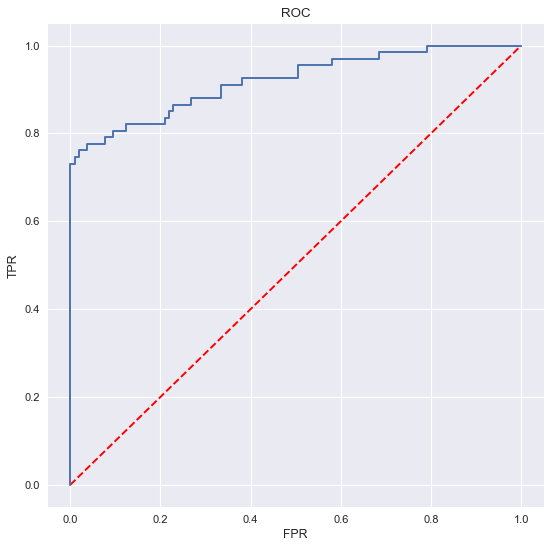

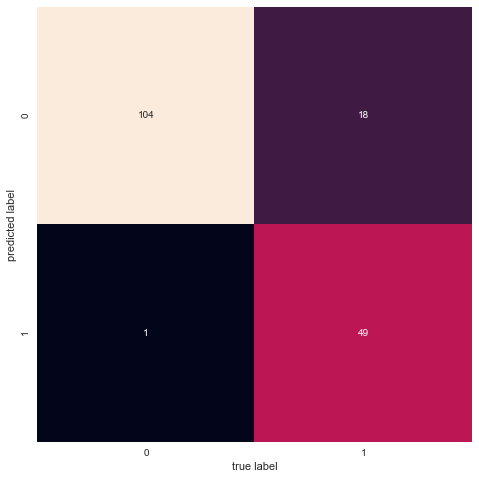

NaiveBayes_45438a99acf2edea8ee7

In [21]:
model = NaiveBayes()

fit_classification(model, model_name='Naive Bayes')

#### Logisitc Regression

CV Average Metrics:  [0.9882577339596283, 0.9830066266517169, 0.9848725686807024, 0.982729094586259, 0.9837160679709307, 0.979558909816347, 0.9805130374628289, 0.49999999999999994, 0.49999999999999994]
Accuracy:  0.9476744186046512
Recall:  0.9253731343283582
Precision:  0.9393939393939394
F_Score:  0.9323308270676692
ROC-AUC:  0.9917555081734186


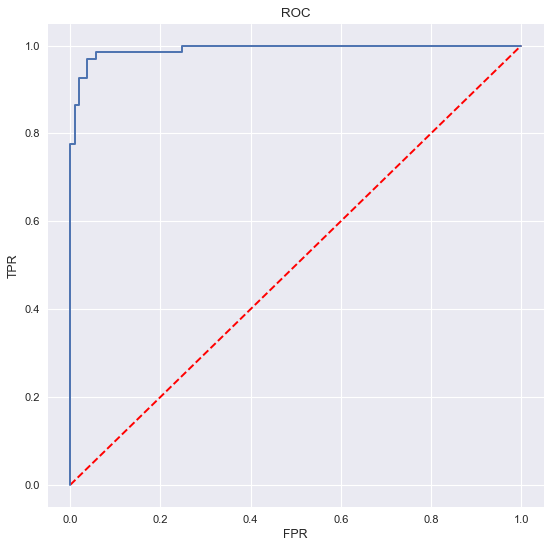

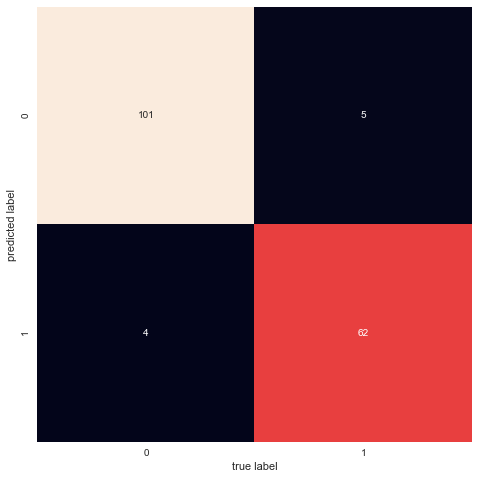

In [22]:
model = LogisticRegression(maxIter=20)
paramGrid = ParamGridBuilder().addGrid(model.regParam, [0.01,0.1,0.99]).addGrid(model.elasticNetParam, [0.001,0.5,0.99]).build()

log_reg = fit_classification(model, params=paramGrid, model_name='Logistic Regression')

#### Random Forrest

CV Average Metrics:  [0.9827684910436626, 0.9848142196061667, 0.9853773108873896, 0.9893188287460732, 0.9897113483221135, 0.989343433927875, 0.9899369074552898, 0.9889546410229292, 0.9892229732061808]
Accuracy:  0.9651162790697675
Recall:  0.9552238805970149
Precision:  0.9552238805970149
F_Score:  0.9552238805970149
ROC-AUC:  0.9873489694385217


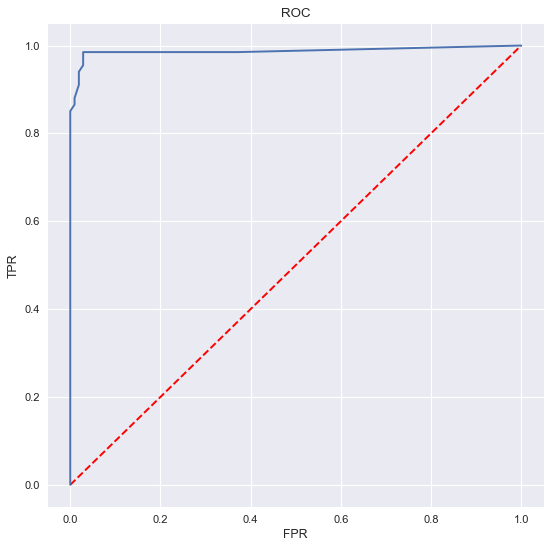

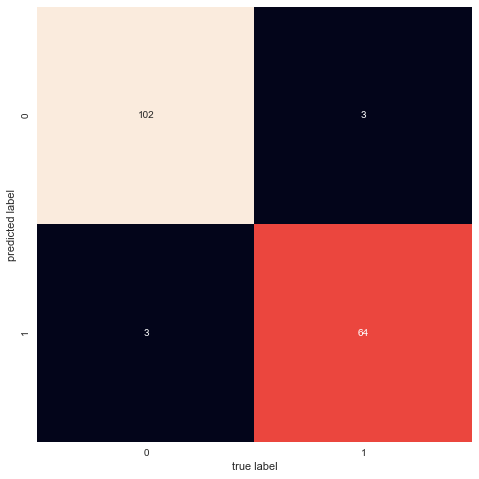

RandomForestClassificationModel (uid=RandomForestClassifier_49338a84cfe36819e336) with 20 trees

In [23]:
model = RandomForestClassifier()
paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [2, 5, 15]).addGrid(model.maxBins, [5, 30,50]).build()

fit_classification(model, params=paramGrid, model_name='Random Forest')

#### MLP

CV Average Metrics:  [0.9670515452065523, 0.9421602574202508, 0.4161568436307526]
Accuracy:  0.8895348837209303
Recall:  0.7313432835820896
Precision:  0.98
F_Score:  0.8376068376068375
ROC-AUC:  0.9529495380241649


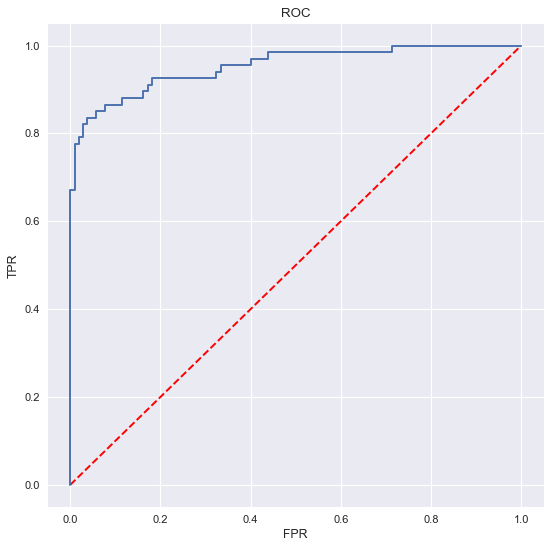

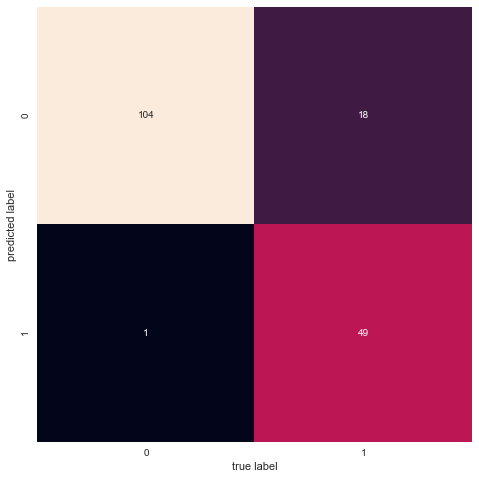

MultilayerPerceptronClassifier_4a7c8c3b46f64384c488

In [24]:
model = MultilayerPerceptronClassifier()
layer_list = [[30,100,100,2],
              [30,10,10,2],
              [30, 10, 2]]

paramGrid = ParamGridBuilder().addGrid(model.layers, layer_list).build()

fit_classification(model, params=paramGrid, model_name='MLP')

In [41]:
print_tracer_graphs()

<img src='model_performance.png'>

#### Model Results

Comparing the results, we are very happy to see Random Forest and Logistic Regression do much better than the baseline classifier, and that they both have AUC-ROC ~0.99.  Random Forest has the higher Recall score, so moving forward we will recommend using the Random Forest as the classifier. It is important to note that the Random Forest precision metric is high as well, indicating it is not achieving the high recall score by diagnosing all growths as malignant.

#### Result Robustness

Our dataset is very small (under 600 points), therefore we want to make sure the above results aren't due to a lucky random  train, test split.  Therefore, we will run cross validation on 50 different splits and look at the average scores for the different models.

In [8]:
def train_test_50(model, params=None, features=all_features,numFolds=10, model_name='model'):
    '''
    Run model through 50 cross validation iterations using
    a different train/test split.  Record metrics after each
    iteration
    '''
    acc_scores = []
    auc_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for i in range(50):
        # Prepare Data
        (trainingData, testData) = data.randomSplit([0.7, 0.3])
        label_indexer = StringIndexer(inputCol = "diagnosis", outputCol = "label")
        assembler = VectorAssembler(
            inputCols=[x for x in data.columns if x in features],
            outputCol='features')
        pipeline = Pipeline(stages=[assembler,label_indexer])
        pf = pipeline.fit(data)
        train = pf.transform(trainingData)
        test = pf.transform(testData)

        # Train Model
        crossval = CrossValidator(estimator=model,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=BinaryClassificationEvaluator(),
                                  numFolds=numFolds)
        cvModel = crossval.fit(train)
        best_model = cvModel.bestModel

        try:
            trainingSummary = best_model.summary

            # Set the model threshold to maximize F-Measure
            fMeasure = trainingSummary.fMeasureByThreshold
            maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
            bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
                .select('threshold').head()['threshold']
            best_model.setThreshold(1)

        except:
            pass



        # Print results on test
        y_pred = best_model.transform(test)
        predictions = [int(row['prediction']) for row in y_pred.select('prediction').collect()]
        labels = [int(row['label']) for row in y_pred.select('label').collect()]
        probs = [list(row['probability']) for row in y_pred.select('probability').collect()]
        probs = np.array(probs)[:,1]
        
        accuracy = accuracy_score(labels, predictions)
        acc_scores.append(accuracy)
        recall = recall_score(labels, predictions)
        recall_scores.append(recall)
        precision = precision_score(labels, predictions)
        precision_scores.append(precision)
        f_score = f1_score(labels, predictions)
        f1_scores.append(f_score)
        auc  = roc_auc_score(labels, probs)
        auc_scores.append(auc)

    Models.append(model_name)
    Accuracy.append(np.mean(acc_scores))
    Recall.append(np.mean(recall_scores))
    Precision.append(np.mean(precision_scores))
    F1.append(np.mean(f1_scores))
    AUC.append(np.mean(auc_scores))

In [9]:
# model score lists
Models = []
Accuracy = []
AUC = []
F1 = []
Precision = []
Recall = []

In [10]:
model = LogisticRegression(maxIter=20)
paramGrid = ParamGridBuilder().addGrid(model.regParam, [0.01,0.1,0.99]).addGrid(model.elasticNetParam, [0.001,0.5,0.99]).build()

log_reg = train_test_50(model, params=paramGrid, model_name='Logistic Regression')

In [11]:
model = RandomForestClassifier()
paramGrid = ParamGridBuilder().addGrid(model.maxDepth, [2,5,15]).addGrid(model.maxBins, [5, 30,50]).build()

train_test_50(model, params=paramGrid, model_name='Random Forest')

In [12]:
model = NaiveBayes()

train_test_50(model, model_name='Naive Bayes')

In [13]:
model = MultilayerPerceptronClassifier()
layer_list = [[30,100,100,2],
              [30,10,10,2],
              [30, 10, 2]]

paramGrid = ParamGridBuilder().addGrid(model.layers, layer_list).build()

train_test_50(model, params=paramGrid, model_name='MLP')

In [16]:
print_tracer_graphs()

<img src='train_test_50_img.png'>

As we can see the average metrics still show that Random Forest has the best recall score, and high precision score, therefore we will stay with the Random Forest model as our classifcation model

#### Feature Importance

Next we want to show which features are the most important at diagnosing malignant or benign.  The first way we can do this is by looking at feature importance from the Random Forest Model.  Feature importance is measured by the amount of decrease in impurity created by splitting on a feature. A high importance score indicates the feature is better at separating malginant from benign growths.

In [ ]:
# Creating a safe copy
bc_swarm = pd.concat([bc_target,bc_features_scaled],axis=1)

bc_swarm_imp = bc_swarm

bc_swarm_imp['diagnosis'] = bc_swarm_imp['diagnosis'].map({'M':1, 'B':0})

cols = list(bc_swarm_imp.columns)

# Deleting the diagnosis problem
del cols[0]
Y = bc_swarm_imp['diagnosis'].values
X = bc_swarm_imp[cols].values
names = np.array(cols)
rf = RandomForestRegressor()
rf.fit(X, Y)
print("Features sorted by their score:")
feature_data = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

feature_dataframe = pd.DataFrame(feature_data)


figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
plt.xlabel('Importance Score')
plt.ylabel('Feature Names')
plt.title('Feature Importance by Random Forest Regressor')
plt.barh(feature_dataframe[1], feature_dataframe[0])
plt.show()

<img src='rf_features.png'>

We can also look at feature importance by running a simple logistic regression on each feature.

In [16]:
# model score lists
Models = []
Accuracy = []
AUC = []
F1 = []
Precision = []
Recall = []

In [17]:
for feature in all_features:
    model = LogisticRegression(maxIter=20)
    paramGrid = ParamGridBuilder().addGrid(model.regParam, [0.01,0.1,0.99]).addGrid(model.elasticNetParam, [0.001,0.5,0.99]).build()

    log_reg = fit_classification(model, params=paramGrid, features=[feature], model_name=feature, print_to_screen=False)

In [18]:
print_tracer_graphs(top_n=30)

<img src='simple_regression.png'>

Both from the random forest feature importance and simple regressions, it seems that the size (perimeter, area, and radius) of the cell nuclei and the concavity (concave points and concavity) of the cell nuclei are very importance at diagnosing a growth.  Specifically, we see perimeter worst and concave points worst as the two best features at predicting malignant vs benign breast growths. On the other hand, other features such as texture and smoothness are unneccesary to know for diagnosis.

## How can our models and findings be utilized?

First of all, we have created a very accurate model in the random forest model that can be used by doctors to make a quick, time efficient, and cost efficient initial diagnosis.  Many of the tests doctors perform to diagnose growths take multiple days.  We are not saying to rely solely on our model, but if the doctors can easily get the cell feature measurements, they can quickly run our model to give a diagnosis they have a high degree of confidence in. This will allow the patient to know their best next steps immediately, rather than waiting multiple days before taking action.

Additionally, isolating the most important features in malignant cancer identification will be very helpful to doctors that are not able to precisely measure all features with ease.  They can put more effort in just measuring a couple of the more important features, such as perimeter or concavity, and use those to  get a quick and accurate diagnosis.  This will allow doctors and patients to still take their next steps with confidence until further test results come back

This is only the first step in implementing machine learning to help with breast cancer diagnosis, but it is a very promising first step, and should encourage medical professionals to further investigate implementating this technology to improve their practices.